# Business Network: Policy Analysis

In this notebook, I hope to identify the costs and benefits of particular alterations to the network when I commit the network to particular policies.

In [55]:
#imports

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cPickle as cpkl #for serialization
from IPython.display import display, HTML

#constants

%matplotlib inline
sns.set_style("dark")
sigLev = 3
figWidth = figHeight = 5

#useful functions

def getEdgeInfo(edgeVec,keyName):
    #helper for returning a list of edge information over the whole list of
    #edges
    edgeInfoDict = {"edgeID":[],keyName:[]}
    for edgeTup in edgeVec:
        #0th entry is ID
        edgeInfoDict["edgeID"].append(edgeTup[0])
        #then get key info
        givenEdgeDict = edgeTup[2]
        edgeInfoDict[keyName].append(givenEdgeDict[keyName])
    return edgeInfoDict

def getNodeInfo(nodeVec,keyName):
    #helper for returning a list of node information over the whole list of
    #nodes
    nodeInfoDict = {"nodeID":[],keyName:[]}
    for nodeTup in nodeVec:
        #0th entry is ID
        nodeInfoDict["nodeID"].append(nodeTup[0])
        #then get key info
        givenNodeDict = nodeTup[1]
        nodeInfoDict[keyName].append(givenNodeDict[keyName])
    return nodeInfoDict

def makeDensity(givenFrame,givenCountVar):
    #helper that makes density in the given frame
    givenFrame["density"] = (givenFrame[givenCountVar] / 
                                sum(givenFrame[givenCountVar]))
    return givenFrame

def sortAndRank(givenFrame,givenSortVar,withLog = True):
    #helper that sorts and ranks a given dataframe over a sorting variable
    givenFrame = givenFrame.sort_values(givenSortVar,ascending = False)
    givenFrame["rank"] = range(givenFrame.shape[0])
    if (withLog): #add log rang
        givenFrame["logRank"] = np.log(givenFrame["rank"] + 1)
    return givenFrame

In [56]:
#load in dataset
mainNetwork = nx.read_gpickle("../data/processed/doesBusinessWith.pkl")

## Placement of Intermediaries

After studying some of the [clustering aspects of our network](businessNetworkClusterAnalysis.ipynb), it is apparent that intermediaries have extremely low clustering in this network. This suggests a level of fragility that would occur if intermediaries were removed from the network or disconnected from the network. Let us study where these intermediaries are located.

In [57]:
nodeVec = mainNetwork.nodes(data = True)
#get agent types and country codes
countryCodeFrame = pd.DataFrame(getNodeInfo(nodeVec,"countrycodes"))
agentTypeFrame = pd.DataFrame(getNodeInfo(nodeVec,"entType"))

In [58]:
#merge the two
countryAgentFrame = agentTypeFrame.merge(countryCodeFrame,on = "nodeID")
#only consider intermediaries
intermediaryCountryFrame = countryAgentFrame[countryAgentFrame["entType"] ==
                                             "Intermediaries"]
#then group this by country count
intCountryCountFrame = intermediaryCountryFrame.groupby("countrycodes",
                                            as_index = False)["nodeID"].count()
#get density and rank
intCountryCountFrame = makeDensity(intCountryCountFrame,"nodeID")
intCountryCountFrame = sortAndRank(intCountryCountFrame,"density")

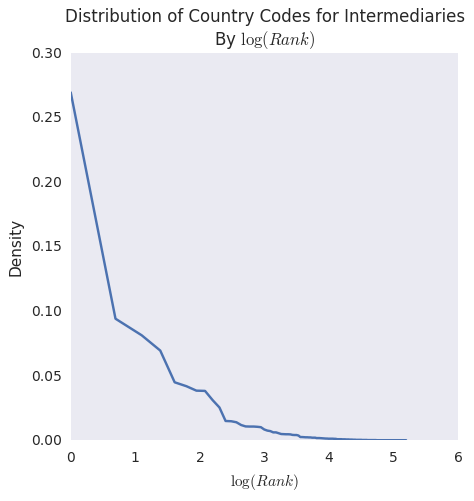

In [59]:
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.plot(intCountryCountFrame["logRank"],intCountryCountFrame["density"])
plt.xlabel("$\log(Rank)$")
plt.ylabel("Density")
plt.title("Distribution of Country Codes for Intermediaries\nBy $\log(Rank)$")

_Figure 1: Distribution of Country Codes for Intermediaries by $\log(Rank).$_

We see that most of the distribution fades off after the top $e^3 \approx 21$ most frequent country codes in our distribution. This is slightly less dense than the distribution of country codes for the overall network, where the distribution fades out after $e^5 \approx 55$ most frequent country codes in our overall network. This suggests that the distribution of country codes for intermediaries is more concentrated than the distribution for the overall network.

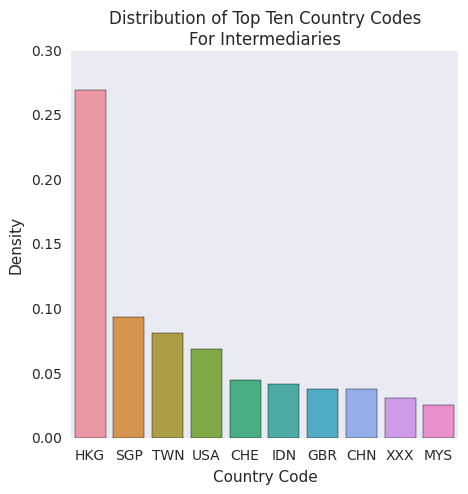

In [60]:
topLev = 10
topTenCountryCodesForIntFrame = intCountryCountFrame.iloc[0:topLev,:]
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "countrycodes",y = "density",
            data = topTenCountryCodesForIntFrame)
plt.xlabel("Country Code")
plt.ylabel("Density")
plt.title("Distribution of Top Ten Country Codes\nFor Intermediaries")

_Figure 2: Distribution of the Top Ten Country Codes for Intermediaries._

We see that an overwhelming number of our intermediaries are in Hong Kong, and they represent a huge amount of the distribution. We see that as with our top ten country codes for all agents in the network, Singapore (SGP), Taiwan (TWN), the United States (USA), China (CHN), and the United Kingdom (GBR) show up as very frequent in the distribution of country codes for intermediaries. Interestingly, certain Southeast Asian countries such as Indonesia (IDN) and Malaysia (MYS) also show up in this network, which suggests a potential importance of these intermediaries in their relationship with tax havens set up to account for China and Taiwan.

In [61]:
#get proportion connections for Intermediaries
def makePropConnections(nodeID):
    #helper that builds the proportion of connections for a given node ID
    agentTypes = ["Intermediaries","Entities","Officers"]
    for agentType in agentTypes:
        #initialize number for agent type
        mainNetwork.node[nodeID]["num" + agentType] = 0
    #then move through neighbors
    for neighborID in mainNetwork.neighbors(nodeID):
        neighborAgentType = mainNetwork.node[neighborID]["entType"]
        #add to count of agent type of this neighbor
        mainNetwork.node[nodeID]["num" + neighborAgentType] += 1
    #then make proportions
    for agentType in agentTypes:
        #initialize information for calculating proportions
        propName = "prop" + agentType
        countName = "num" + agentType
        numNeighbors = len(mainNetwork.neighbors(nodeID))
        #then calculate proportion
        mainNetwork.node[nodeID][propName] = (
            float(mainNetwork.node[nodeID][countName]) / numNeighbors)
#perform this for all agents
for nodeID in list(agentTypeFrame["nodeID"]):
    makePropConnections(nodeID)

In [62]:
#get our proportions
propOfficerFrame = pd.DataFrame(getNodeInfo(nodeVec,"propOfficers"))
propEntFrame = pd.DataFrame(getNodeInfo(nodeVec,"propEntities"))
propIntFrame = pd.DataFrame(getNodeInfo(nodeVec,"propIntermediaries"))
#merge these
propFrame = propOfficerFrame.merge(propEntFrame,on = "nodeID")
propFrame = propFrame.merge(propIntFrame,on = "nodeID")
propFrame = propFrame.merge(agentTypeFrame,on = "nodeID")
#then consider only intermediaries
intermediaryNeighborFrame = propFrame[propFrame["entType"] == "Intermediaries"]

Upon a quick analysis, it looks like intermediaries are only connected with entities, and thus officers are not connected with intermediaries. This is a really surprising result given the expected place of intermediaries in the network, and it suggests that removing intermediaries may not have the desired effect that we would expect on the network. Nonetheless, let us see what certain policy decisions could do to the network.

## Delete all Intermediaries

Let us see what happens to some of our network aspects when we remove all intermediaries from the network.

In [63]:
intermediaryNodes = list(intermediaryNeighborFrame["nodeID"])
mainNetwork.remove_nodes_from(intermediaryNodes)

In [64]:
#check number of components in this network
numConnectedComponents = nx.number_connected_components(mainNetwork)

We see that after removing all intermediaries from the network, we have {{numConnectedComponents}} connected components in our network, this is a major shattering of our network, and thus it suggests that intermediaries may have been essential for connecting disparate sets of entitites together.

In [65]:
#get largest connected component in network
connectedComponents = nx.connected_components(mainNetwork)
largestCC = max(connectedComponents,key = len)
propLargestCC = float(len(largestCC)) / len(mainNetwork.nodes())
percentMul = 100
percentLargestCC = propLargestCC * percentMul

We see that {{int(np.round(percentLargestCC))}}% of the network is now in the largest connected component.

In [66]:
degreeDict = nx.degree_centrality(mainNetwork)
degreeFrame = pd.DataFrame({"nodeID":degreeDict.keys(),
                            "degree":degreeDict.values()})
#recalculate degree
degreeFrame["degree"] = degreeFrame["degree"] * degreeFrame.shape[0]
degreeFrame["logDegree"] = np.log(degreeFrame["degree"] + 1)

1.42010129602


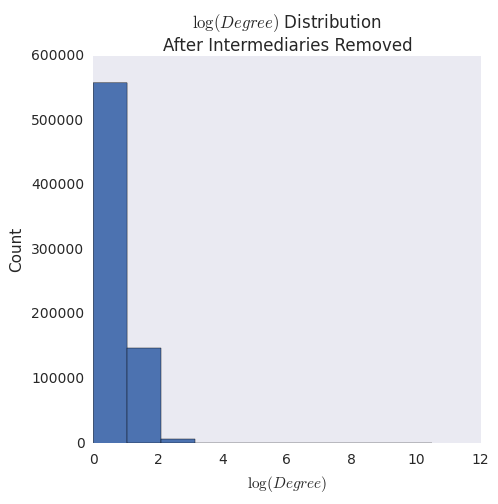

In [70]:
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.hist(degreeFrame["logDegree"])
plt.xlabel("$\log(Degree)$")
plt.ylabel("Count")
plt.title("$\log(Degree)$ Distribution\nAfter Intermediaries Removed")
plt.savefig("figures/figure10.png")
avgDegree = degreeFrame["degree"].mean()
print avgDegree

## Intervention 2: China limits intermediation

In [72]:
mainNetwork = nx.read_gpickle("../data/processed/doesBusinessWith.pkl")

In [73]:
#get intermediaries located in China
chineseIntermediaryList = []
for node in mainNetwork.nodes(data = True):
    if (node[1]["entType"] == "Intermediaries" and
        node[1]["countrycodes"] == "CHN"):
        chineseIntermediaryList.append(node[0])
#then remove
mainNetwork.remove_nodes_from(chineseIntermediaryList)

In [74]:
numConnectedComponents = nx.number_connected_components(mainNetwork)

We see that there are now {{numConnectedComponents}} connected components in this graph.

In [75]:
#get largest connected component in network
connectedComponents = nx.connected_components(mainNetwork)
largestCC = max(connectedComponents,key = len)
propLargestCC = float(len(largestCC)) / len(mainNetwork.nodes())
percentMul = 100
percentLargestCC = propLargestCC * percentMul

We see that {{int(np.round(percentLargestCC))}}% of this network is in the largest connected component.

In [76]:
degreeDict = nx.degree_centrality(mainNetwork)
degreeFrame = pd.DataFrame({"nodeID":degreeDict.keys(),
                            "degree":degreeDict.values()})
#recalculate degree
degreeFrame["degree"] = degreeFrame["degree"] * degreeFrame.shape[0]
degreeFrame["logDegree"] = np.log(degreeFrame["degree"] + 1)

2.50321408454


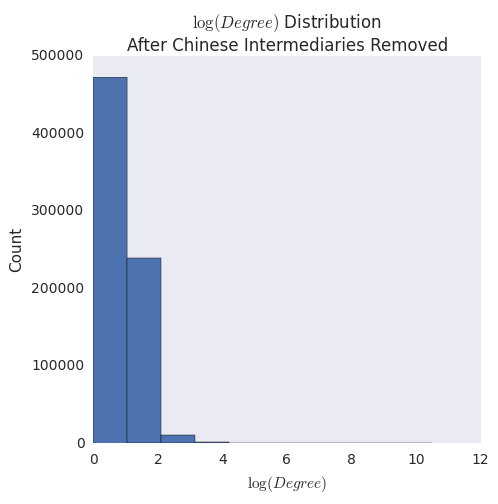

In [77]:
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.hist(degreeFrame["logDegree"])
plt.xlabel("$\log(Degree)$")
plt.ylabel("Count")
plt.title("$\log(Degree)$ Distribution\nAfter Chinese Intermediaries Removed")
plt.savefig("figures/figure11.png")
avgDegree = degreeFrame["degree"].mean()
print avgDegree

## Intervention 3: Great Britain and the United States limit entity interaction rate

In [78]:
mainNetwork = nx.read_gpickle("../data/processed/doesBusinessWith.pkl")

In [79]:
#get gbr and us intermediaries
givenIntermediaryList = []
for node in mainNetwork.nodes(data = True):
    if (node[1]["entType"] == "Intermediaries" and
       (node[1]["countrycodes"] == "GBR" or node[1]["countrycodes"] == "USA")):
        givenIntermediaryList.append(node[0])

In [80]:
entityRelationCap = 5
import random
#get edges to remove due to cap
edgeRemovalList = []
for node in givenIntermediaryList:
    edgeList = mainNetwork.edges(node)
    if (len(edgeList) > entityRelationCap): #need to remove some
        numToRemove = len(edgeList) - entityRelationCap
        edgesToRemove = random.sample(edgeList,numToRemove)
        edgeRemovalList.extend(edgesToRemove)
#let's remove them
mainNetwork.remove_edges_from(edgeRemovalList)

In [81]:
numConnectedComponents = nx.number_connected_components(mainNetwork)

{{numConnectedComponents}}

In [83]:
#get number of edges
numEdges = len(mainNetwork.edges())
print numEdges

889689


In [84]:
#get largest connected component in network
connectedComponents = nx.connected_components(mainNetwork)
largestCC = max(connectedComponents,key = len)
propLargestCC = float(len(largestCC)) / len(mainNetwork.nodes())
percentMul = 100
percentLargestCC = propLargestCC * percentMul

We see that {{int(np.round(percentLargestCC))}}% of the nodes remain in the largest connected component

In [85]:
degreeDict = nx.degree_centrality(mainNetwork)
degreeFrame = pd.DataFrame({"nodeID":degreeDict.keys(),
                            "degree":degreeDict.values()})
#recalculate degree
degreeFrame["degree"] = degreeFrame["degree"] * degreeFrame.shape[0]
degreeFrame["logDegree"] = np.log(degreeFrame["degree"] + 1)

2.45532031743


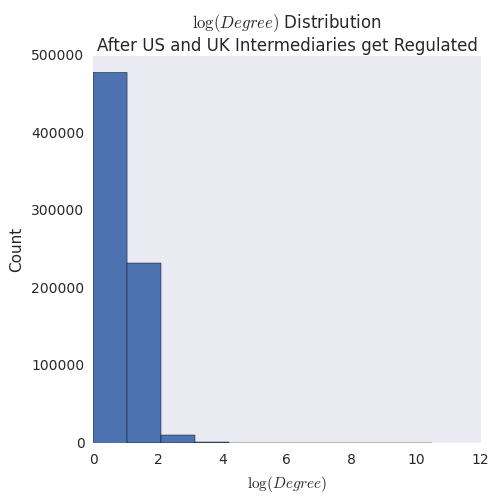

In [86]:
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.hist(degreeFrame["logDegree"])
plt.xlabel("$\log(Degree)$")
plt.ylabel("Count")
plt.title("$\log(Degree)$ Distribution\n" +
          "After US and UK Intermediaries get Regulated")
plt.savefig("figures/figure12.png")
avgDegree = degreeFrame["degree"].mean()
print avgDegree